In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision

from tqdm.notebook import tqdm

In [2]:
try:
    from torchsummary import summary
except ModuleNotFoundError: 
    !pip install torchsummary
    from torchsummary import summary

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"TORCH DEVICE: {device}")

TORCH DEVICE: cuda


In [4]:
train_dir = '../input/gravity-spy-gravitational-waves/train/train/'
test_dir = '../input//gravity-spy-gravitational-waves/test/test/'
validation_dir = '../input//gravity-spy-gravitational-waves/validation/validation/'

In [5]:
class_names = os.listdir(train_dir)
n_classes=len(class_names)
n_classes

22

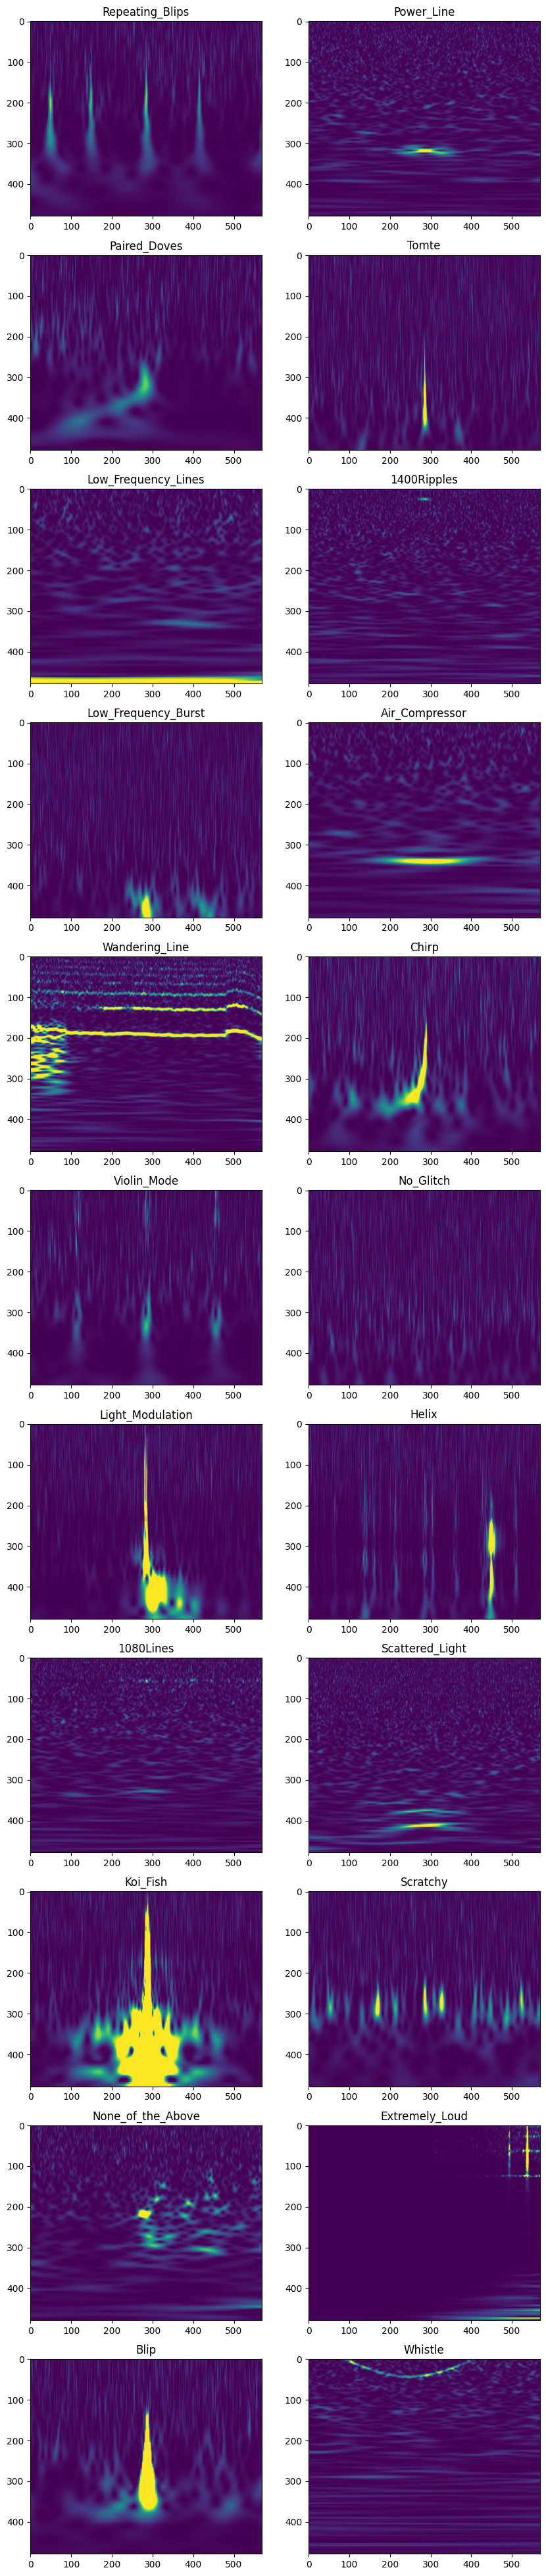

In [6]:
plt.figure(figsize=(10,50))
for fold, i in zip(class_names,range(0,len(class_names))):

    plt.subplot(11,2, i+1)
    img_read = plt.imread(train_dir+fold+'/'+os.listdir(train_dir+fold)[0])
    plt.imshow(img_read)
    plt.title(class_names[i])
    
plt.show()

In [7]:
img_shape=(64,64)
batch_size=128

In [8]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(img_shape),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Grayscale(),
                                torchvision.transforms.Normalize((0.5), (0.5))])



In [9]:
train_set = torchvision.datasets.ImageFolder(train_dir, transform)
val_set = torchvision.datasets.ImageFolder(validation_dir,transform)
#test_set = torchvision.datasets.ImageFolder(test_dir,transform)

In [10]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

## Network utility

taken from: https://www.kaggle.com/code/umongsain/vision-transformer-from-scratch-pytorch

In [11]:
def patchify(batch, patch_size):
    """
    Patchify the batch of images
        
    Shape:
        batch: (b, h, w, c)
        output: (b, nh, nw, ph, pw, c)
    """
    b, c, h, w = batch.shape
    ph, pw = patch_size
    nh, nw = h // ph, w // pw

    batch_patches = torch.reshape(batch, (b, c, nh, ph, nw, pw))
    batch_patches = torch.permute(batch_patches, (0, 1, 2, 4, 3, 5))

    return batch_patches



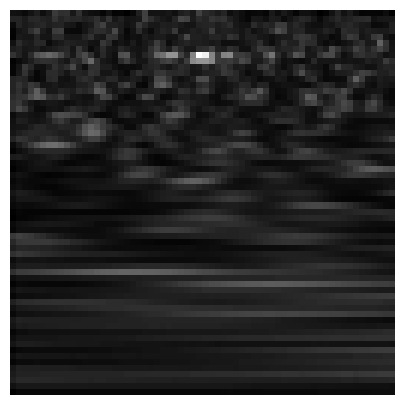

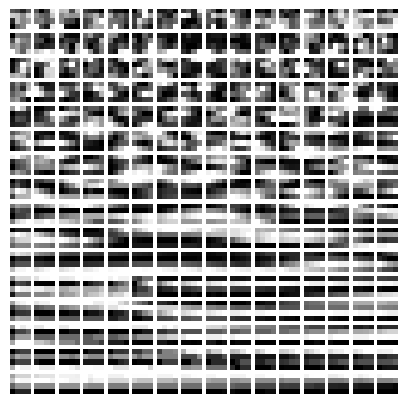

In [12]:
data,_=train_set[4]
patch_size = (4, 4)
batch_patches = patchify(data.unsqueeze(0), patch_size)

patches = batch_patches[0]
c, nh, nw, ph, pw = patches.shape

plt.figure(figsize=(5, 5))
plt.imshow(data[0], cmap="gray")
plt.axis("off")

plt.figure(figsize=(5, 5))
for i in range(nh):
    for j in range(nw):
        plt.subplot(nh, nw, i * nw + j + 1)
        plt.imshow(patches[0, i, j], cmap="gray")
        plt.axis("off")

In [13]:
def get_mlp(in_features, hidden_units, out_features):
    """
    Returns a MLP head
    """
    dims = [in_features] + hidden_units + [out_features]
    layers = []
    for dim1, dim2 in zip(dims[:-2], dims[1:-1]):
        layers.append(nn.Linear(dim1, dim2))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(dims[-2], dims[-1]))
    return nn.Sequential(*layers)


In [14]:
class Img2Seq(nn.Module):
    """
    This layers takes a batch of images as input and
    returns a batch of sequences
    
    Shape:
        input: (b, h, w, c)
        output: (b, s, d)
    """
    def __init__(self, img_size, patch_size, n_channels, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size

        nh, nw = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        n_tokens = nh * nw

        token_dim = patch_size[0] * patch_size[1] * n_channels
        self.linear = nn.Linear(token_dim, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb = nn.Parameter(torch.randn(n_tokens, d_model))

    def __call__(self, batch):
        batch = patchify(batch, self.patch_size)

        b, c, nh, nw, ph, pw = batch.shape

        # Flattening the patches
        batch = torch.permute(batch, [0, 2, 3, 4, 5, 1])
        batch = torch.reshape(batch, [b, nh * nw, ph * pw * c])

        batch = self.linear(batch)
        cls = self.cls_token.expand([b, -1, -1])
        emb = batch + self.pos_emb

        return torch.cat([cls, emb], axis=1)

In [15]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        n_channels,
        d_model,
        nhead,
        dim_feedforward,
        blocks,
        mlp_head_units,
        n_classes,
    ):
        super().__init__()
        
        """
        Args:
            img_size: Size of the image
            patch_size: Size of the patch
            n_channels: Number of image channels
            d_model: The number of features in the transformer encoder
            nhead: The number of heads in the multiheadattention models
            dim_feedforward: The dimension of the feedforward network model in the encoder
            blocks: The number of sub-encoder-layers in the encoder
            mlp_head_units: The hidden units of mlp_head
            n_classes: The number of output classes
        """
        self.img2seq = Img2Seq(img_size, patch_size, n_channels, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, activation="gelu", batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, blocks
        )
        self.mlp = get_mlp(d_model, mlp_head_units, n_classes)
        
        self.output = nn.Sigmoid() if n_classes == 1 else nn.Softmax(-1)

    def __call__(self, batch):

        batch = self.img2seq(batch)
        batch = self.transformer_encoder(batch)
        batch = batch[:, 0, :]
        batch = self.mlp(batch)
        output = self.output(batch)
        return output

In [16]:
img_size = img_shape
patch_size = (4, 4)
n_channels = 1
d_model = 512
nhead = 4
dim_feedforward =512
blocks = 3
mlp_head_units = [256, 128, 64]

In [17]:
model = ViT(
    img_size = img_size,
    patch_size = patch_size,
    n_channels = 1,
    d_model = d_model,
    nhead = nhead,
    dim_feedforward = dim_feedforward,
    blocks = blocks,
    mlp_head_units = mlp_head_units,
    n_classes = n_classes,
).to(device)


In [18]:
def train(epoch,net,optimizer,scheduler, criterion,train_loader, val_loader):
    for epoch in tqdm(range(epoch)):  
        train_loss = 0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += predicted_train.eq(labels.to(device)).cpu().sum().item()
        scheduler.step()
        train_accuracy = 100 * correct_train / total_train
        val_accuracy = evaluate_accuracy(net, val_loader)
        print('Epoch %d, train loss: %.3f, train accuracy: %.2f%%, val accuracy: %.2f%%' %
              (epoch + 1, train_loss / len(train_loader), train_accuracy, val_accuracy))
        
    print('Finished Training')
    
def evaluate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0) 
            correct += (predicted == labels.to(device)).sum().item() 
    accuracy = 100 * correct / total  
    return accuracy

def accuracy_classes(net,dataloader,classes): 
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels.to(device), predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 35], gamma=0.1)
epoch=40
criterion = nn.CrossEntropyLoss()

In [20]:
train(epoch,model,optimizer,scheduler, criterion,train_loader, val_loader)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1, train loss: 2.962, train accuracy: 26.28%, val accuracy: 38.96%
Epoch 2, train loss: 2.747, train accuracy: 42.61%, val accuracy: 48.23%
Epoch 3, train loss: 2.656, train accuracy: 51.47%, val accuracy: 53.42%
Epoch 4, train loss: 2.607, train accuracy: 56.32%, val accuracy: 58.33%
Epoch 5, train loss: 2.575, train accuracy: 59.38%, val accuracy: 59.77%
Epoch 6, train loss: 2.568, train accuracy: 59.90%, val accuracy: 59.88%
Epoch 7, train loss: 2.560, train accuracy: 60.69%, val accuracy: 60.33%
Epoch 8, train loss: 2.533, train accuracy: 63.66%, val accuracy: 65.62%
Epoch 9, train loss: 2.515, train accuracy: 65.36%, val accuracy: 65.46%
Epoch 10, train loss: 2.511, train accuracy: 65.67%, val accuracy: 66.02%
Epoch 11, train loss: 2.505, train accuracy: 66.24%, val accuracy: 66.50%
Epoch 12, train loss: 2.502, train accuracy: 66.40%, val accuracy: 66.50%
Epoch 13, train loss: 2.497, train accuracy: 66.97%, val accuracy: 66.85%
Epoch 14, train loss: 2.499, train accuracy: 66

In [21]:
accuracy_classes(model,val_loader,class_names)   

Accuracy for class: Repeating_Blips is 0.0 %
Accuracy for class: Power_Line is 0.0 %
Accuracy for class: Paired_Doves is 0.0 %
Accuracy for class: Tomte is 97.5 %
Accuracy for class: Low_Frequency_Lines is 0.0 %
Accuracy for class: 1400Ripples is 87.3 %
Accuracy for class: Low_Frequency_Burst is 0.0 %
Accuracy for class: Air_Compressor is 92.0 %
Accuracy for class: Wandering_Line is 75.0 %
Accuracy for class: Chirp is 89.6 %
Accuracy for class: Violin_Mode is 84.5 %
Accuracy for class: No_Glitch is 0.0 %
Accuracy for class: Light_Modulation is 0.0 %
Accuracy for class: Helix is 0.0 %
Accuracy for class: 1080Lines is 98.9 %
Accuracy for class: Scattered_Light is 0.0 %
Accuracy for class: Koi_Fish is 97.1 %
Accuracy for class: Scratchy is 0.0 %
Accuracy for class: None_of_the_Above is 0.0 %
Accuracy for class: Extremely_Loud is 81.6 %
Accuracy for class: Blip  is 0.0 %
Accuracy for class: Whistle is 64.1 %
